# Plotting Market Data 

In [1]:
from kraken.spot import Market

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

____
### 1. Create the unauthenticated market client

In [3]:
market = Market()

### 2. Get the OHLC data of the XBTUSD pair, create the dataframe, and set the time index

In [4]:
df = pd.DataFrame(
    market.get_ohlc(pair='XBTUSD', interval=60)['XXBTZUSD'],
    columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
).astype(float)
# df = df.set_index('time')
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.sort_values(by='time')
df

,time,open,high,low,close,vwap,volume,count
0,2024-03-02 12:00:00,61917.8,62223.7,61911.4,62142.4,62048.6,15.260659,616.0
1,2024-03-02 13:00:00,62142.4,62142.4,61900.0,61900.0,62006.8,50.357137,727.0
2,2024-03-02 14:00:00,61900.1,61971.8,61663.3,61891.7,61832.5,281.512303,1538.0
3,2024-03-02 15:00:00,61891.8,62032.2,61810.0,61836.8,61941.1,38.815926,886.0
4,2024-03-02 16:00:00,61836.8,62022.3,61714.9,61930.8,61839.0,181.980102,1261.0
...,...,...,...,...,...,...,...,...
715,2024-04-01 07:00:00,69680.1,69788.8,69562.0,69671.7,69676.0,40.187037,767.0
716,2024-04-01 08:00:00,69671.8,69671.8,69244.7,69450.0,69445.2,91.352301,1017.0
717,2024-04-01 09:00:00,69450.1,69613.4,69448.6,69448.7,69510.3,46.275460,731.0
718,2024-04-01 10:00:00,69448.7,69604.4,69353.0,69601.1,69454.0,23.874609,556.0


### 3. Compute some indicatoes based on the loaded data

In [5]:
# compute ema
df['ema21'] = df['close'].ewm(span=21, adjust=False, min_periods=21).mean()
df['ema50'] = df['close'].ewm(span=50, adjust=False, min_periods=50).mean()
df['ema200'] = df['close'].ewm(span=200, adjust=False, min_periods=200).mean()

In [6]:
def support_and_resistance(df: pd.DataFrame, lookback: int=200, levels: int=3) -> dict:
    ''' Returns up to 3 support and resistance levels by given dataframe '''
    high = df['high'][-lookback:].max()
    low = df['low'][-lookback:].min()
    close = df['close'][-lookback:].iloc[-1]

    pp = (high + low + close) / 3
    s1 = 2 * pp - high
    r1 = 2 * pp - low
    if levels >= 2:
        s2 = pp - (high - low)
        r2 = pp + (high - low)
        if levels >= 3:
            s3 = low - 2 * (high -pp)
            r3 = high + 2 * (pp - low)
            return { 's1': s1, 's2': s2, 's3': s3, 'r1': r1, 'r2': r2, 'r3': r3 }
        return { 's1': s1, 's2': s2, 'r1': r1, 'r2': r2 }
    return { 's1': s1,  'r2': r1 }

In [7]:
# compute support and resistance levels
for i, row in enumerate(df.index):
    try:
        srlevels = support_and_resistance(df.iloc[:i], lookback=50, levels=2)
        df.at[row, 's1'] = srlevels['s1']
        df.at[row, 'r1'] = srlevels['r1']
        df.at[row, 's2'] = srlevels['s2']
        df.at[row, 'r2'] = srlevels['r2']
    except:
        df.at[row, 's1'] = np.NaN
        df.at[row, 'r1'] = np.NaN
        df.at[row, 's2'] = np.NaN
        df.at[row, 'r2'] = np.NaN

# isn't that a beauty?:
df

,time,open,high,low,close,vwap,volume,count,ema21,ema50,ema200,s1,r1,s2,r2
0,2024-03-02 12:00:00,61917.8,62223.7,61911.4,62142.4,62048.6,15.260659,616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-02 13:00:00,62142.4,62142.4,61900.0,61900.0,62006.8,50.357137,727.0,NaN,NaN,NaN,61961.300000,62273.600000,61780.200000,62404.800000
2,2024-03-02 14:00:00,61900.1,61971.8,61663.3,61891.7,61832.5,281.512303,1538.0,NaN,NaN,NaN,61792.100000,62115.800000,61684.200000,62331.600000
3,2024-03-02 15:00:00,61891.8,62032.2,61810.0,61836.8,61941.1,38.815926,886.0,NaN,NaN,NaN,61628.766667,62189.166667,61365.833333,62486.633333
4,2024-03-02 16:00:00,61836.8,62022.3,61714.9,61930.8,61839.0,181.980102,1261.0,NaN,NaN,NaN,61592.166667,62152.566667,61347.533333,62468.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2024-04-01 07:00:00,69680.1,69788.8,69562.0,69671.7,69676.0,40.187037,767.0,70380.082934,70315.531093,69369.034227,68659.500000,71012.200000,67639.000000,72344.400000
716,2024-04-01 08:00:00,69671.8,69671.8,69244.7,69450.0,69445.2,91.352301,1017.0,70295.529940,70281.588697,69369.839856,68653.966667,71006.666667,67636.233333,72341.633333
717,2024-04-01 09:00:00,69450.1,69613.4,69448.6,69448.7,69510.3,46.275460,731.0,70218.545400,70248.926395,69370.624534,68506.166667,70858.866667,67562.333333,72267.733333
718,2024-04-01 10:00:00,69448.7,69604.4,69353.0,69601.1,69454.0,23.874609,556.0,70162.414000,70223.521439,69372.917823,68505.300000,70858.000000,67561.900000,72267.300000


### 4. Plot the results

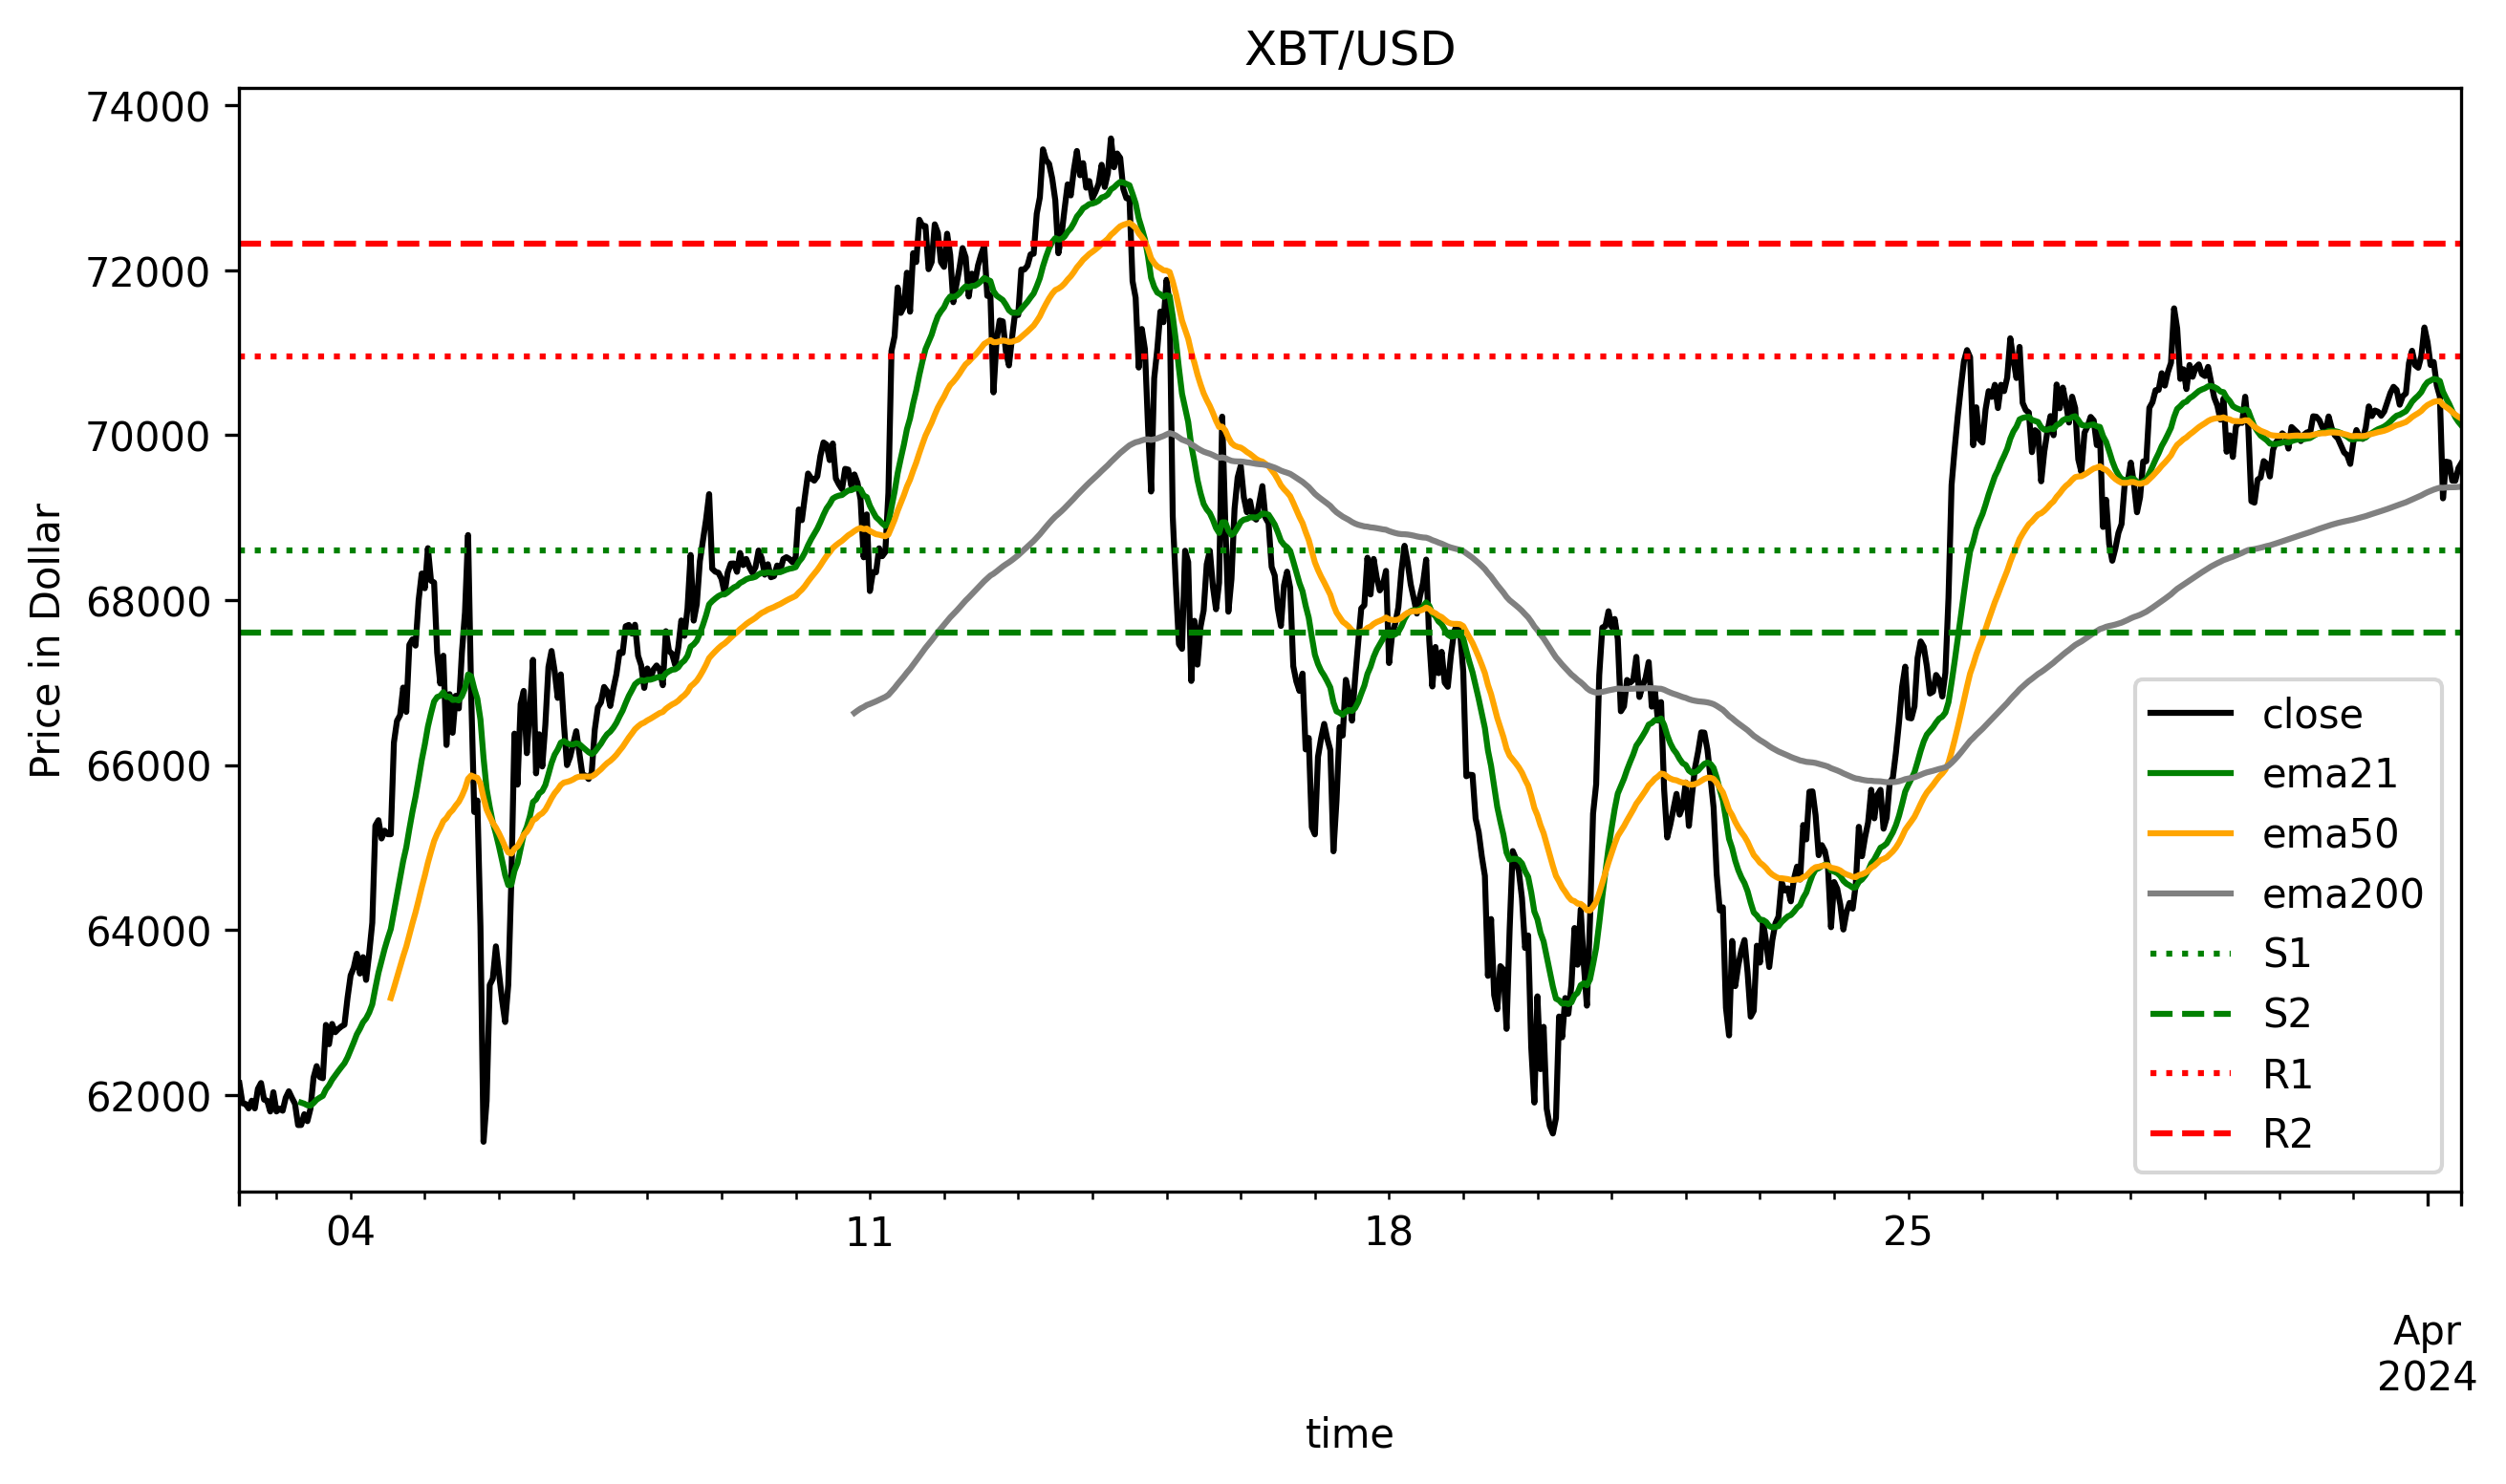

In [8]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax = plt.gca()
df.plot(x='time', y=['close', 'ema21', 'ema50', 'ema200'], ax=ax, color=['black', 'green', 'orange', 'gray'])

xmin, xmax = df['time'].iloc[0], df['time'].iloc[-1]
ax.hlines(y=df['s1'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle=':', label='S1')
ax.hlines(y=df['s2'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle='--', label='S2')
ax.hlines(y=df['r1'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle=':', label='R1')
ax.hlines(y=df['r2'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle='--', label='R2')
ax.set_ylabel('Price in Dollar')
plt.legend()
plt.title('XBT/USD');

… Create and combine custom indicators, implement them, and build your own strategies ...